# Классификация типа дорожного покрытия

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, initializers
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
# import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


### CNN

In [2]:
data = []
labels = []
sumu =0
end = 3500
# input_size = (120,120)
path = "./RSCD/train/Concrete/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if file_number != 'dry_concrete':
#             if count == 1400: break
#         else: 
        if count == end: break
        count = count+1
        imagepath = (path3)
        image = cv2.imread(imagepath, 1) 
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

dry_concrete 3500
water_concrete 3500
wet_concrete 3500
all 10500


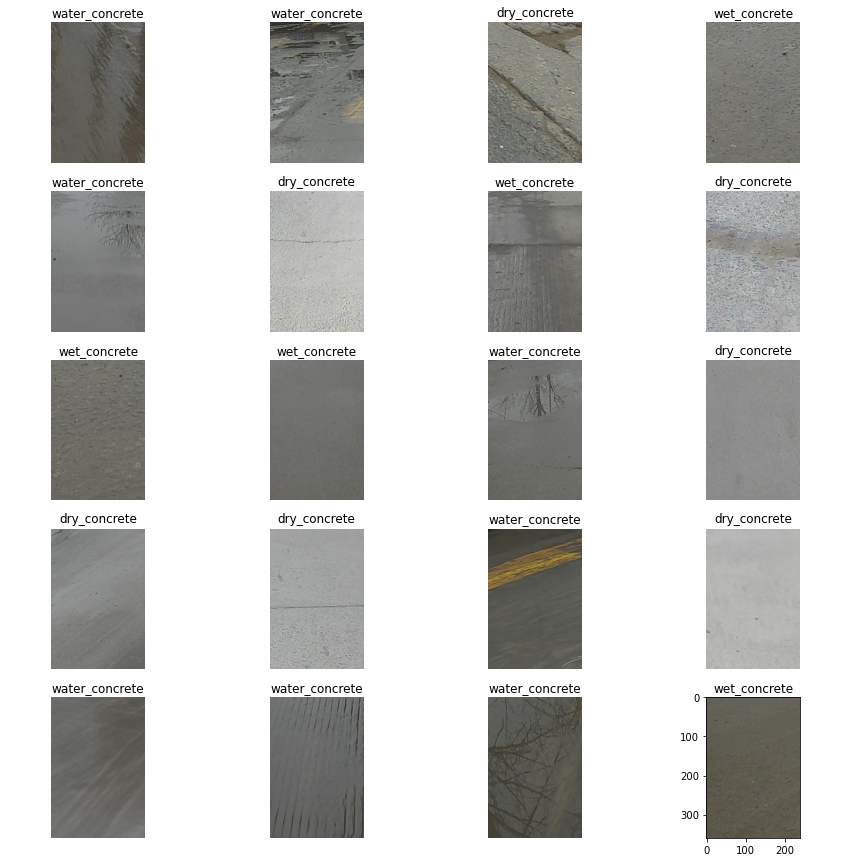

In [3]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.2, stratify = labels)#stratify = labels


from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
from keras.models import Sequential, load_model
import tensorflow_addons as tfa
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2DTranspose
from keras.optimizers import Adam as adam
from keras.optimizers import SGD
from keras.metrics import RootMeanSquaredError
from keras import initializers
import math

initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

#Building the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=5, activation='ReLU', input_shape=np.array(X_train).shape[1:]))
model.add(Conv2D(filters=16, kernel_size=5, activation='ReLU'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.05))

model.add(Conv2D(filters=32, kernel_size=5, activation='ReLU'))
model.add(Conv2D(filters=32, kernel_size=5, activation='ReLU'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=64, kernel_size=3, activation='ReLU'))
model.add(Conv2D(filters=64, kernel_size=3, activation='ReLU'))


model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=128, kernel_size=3, activation='ReLU'))
model.add(Conv2D(filters=128, kernel_size=3, activation='ReLU'))


model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.15))

# model.add(Conv2D(filters=512, kernel_size=3,activation='swish'))
# model.add(Conv2D(filters=512, kernel_size=3,activation='swish'))


# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
# model.add(Dropout(rate=0.15))

# model.add(Conv2D(filters=1024, kernel_size=1,activation='swish'))
# model.add(Conv2D(filters=1024, kernel_size=1,activation='swish'))


# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
# model.add(Dropout(rate=0.25))

model.add(GlobalAveragePooling2D()) 
# model.add(Dense(20, activation='ReLU'))
model.add(Dense(num_classes,kernel_initializer=initializer, bias_initializer=initializer, activation='softmax')) 

model.compile(optimizer = adam(0.00001), loss = 'binary_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary() #categorical

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 356, 236, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 352, 232, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 176, 116, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 176, 116, 16)     64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 176, 116, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 172, 112, 32)      1

In [6]:
# import LRFinder
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=10, batch_size=5, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [7]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_f1_score"]
        accuracy = sum(accuracy) / len(accuracy)
        if accuracy >= self.point:
            self.model.stop_training = True


In [8]:
model = tf.keras.models.load_model('./saved_models/Road_Type_Concrete_CNN.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 356, 236, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 352, 232, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 176, 116, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 176, 116, 16)     64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 176, 116, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 172, 112, 32)      1

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=5, epochs=50,callbacks = [StopOnPoint(0.9)], validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
1680/1680 [==============================] - 107s 61ms/step - loss: 0.3190 - f1_score: 0.8113 - val_loss: 0.3429 - val_f1_score: 0.7940
Epoch 2/50
1680/1680 [==============================] - 105s 62ms/step - loss: 0.3104 - f1_score: 0.8076 - val_loss: 0.5839 - val_f1_score: 0.6333
Epoch 3/50
1680/1680 [==============================] - 104s 62ms/step - loss: 0.3178 - f1_score: 0.8050 - val_loss: 0.3827 - val_f1_score: 0.7645
Epoch 4/50
1680/1680 [==============================] - 105s 62ms/step - loss: 0.3095 - f1_score: 0.8128 - val_loss: 0.4134 - val_f1_score: 0.7279
Epoch 5/50
1680/1680 [==============================] - 105s 62ms/step - loss: 0.3132 - f1_score: 0.8089 - val_loss: 0.3167 - val_f1_score: 0.8016
Epoch 6/50
1680/1680 [==============================] - 105s 63ms/step - loss: 0.3081 - f1_score: 0.8098 - val_loss: 0.4745 - val_f1_score: 0.6913
Epoch 7/50
1680/1680 [==============================] - 107s 64ms/step - loss: 0.3079 - f1_score: 0.8073 - val_loss: 0

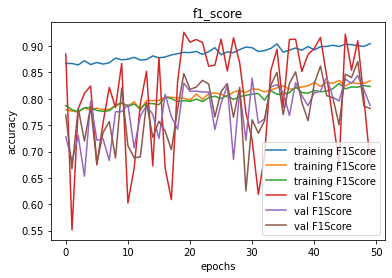

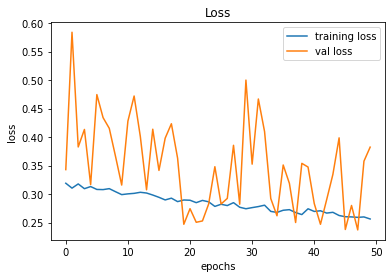

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
test_data = []
test_labels = []
# end=500
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
        count = count+1
        if count >= end:
            if count == end+500: break
            imagepath = (path3)
            image = cv2.imread(imagepath, 1) ## Считываем изображение
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
#             image = cv2.resize(image, input_size)
            test_data.append(image)
            label = file_number
            test_labels.append(label)

In [12]:
len(test_data)

1500

In [13]:
len(test_labels)

1500

In [14]:
test_labels = le.fit_transform(test_labels)
# test_labels = to_categorical(test_labels, num_classes)

In [15]:
predicted_classes = []
for i in range(len(test_data)):
    img_batch = np.expand_dims(test_data[i],0)
    prediction = model.predict(img_batch)
    prediction = np.argmax(prediction, axis=1)
    if prediction != test_labels[i]: print(prediction, '|', test_labels[i])
    predicted_classes.append(prediction[0])

1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 16ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0s 20ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0s 20ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 19ms/step
[1] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0

1/1 [==============================] - 0s 16ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 18ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 16ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 16ms/step
[2] | 0
1/1 [==============================] - 0s 16ms/step
[2] | 0
1/1 [==============================] - 0s 22ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 18ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[2] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 19ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0s 19ms/step
[1] | 0
1/1 [==============================] - 0s 16ms/step
[1] | 0
1/1 [==============================] - 0s 17ms/step
[1] | 0
1/1 [==============================] - 0

1/1 [==============================] - 0s 20ms/step
[1] | 2
1/1 [==============================] - 0s 18ms/step
[1] | 2
1/1 [==============================] - 0s 19ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 21ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 18ms/step
[0] | 2
1/1 [==============================] - 0s 16ms/step
[0] | 2
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
[1] | 2
1/1 [==============================] - 0s 20ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 16ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0s 17ms/step
[1] | 2
1/1 [==============================] - 0

In [16]:
from sklearn.metrics import f1_score
print (f1_score(test_labels, predicted_classes, average='weighted'))

0.5977471026068839


Text(0.5, 0.98, 'Plot of confusion matrix')

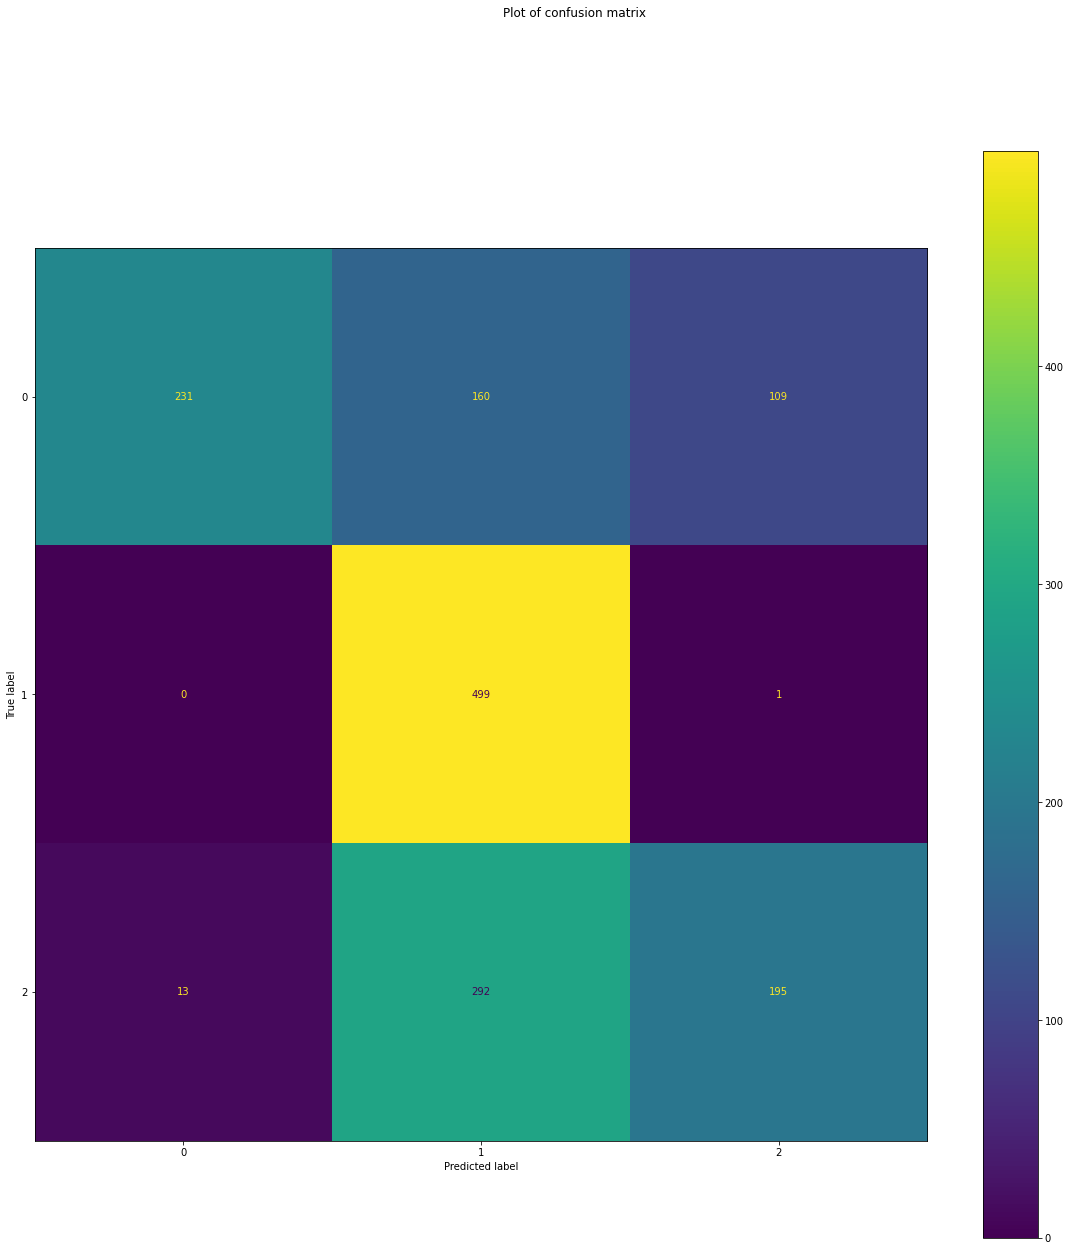

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(test_labels, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')

In [27]:
# model.save('./saved_models/Road_Type_Concrete_CNN.h5')